This is a live notebook with experimental code to develop analysis investigating the correlation between features.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import itertools
import json
import math

import scipy.stats
import seaborn as sns

import os


In [2]:
# This is a hack to make the library in the parent folder available for imoprts
# A better solution is by np8 here:
# https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import sys
import os
import inspect

thisdir = sys.path[0]
print(f"thisdir = {thisdir}")
parentdir = os.path.dirname(thisdir)
#print(f"parentdir = {parentdir}")
if not parentdir in sys.path:
    print("Adding parent directory to python path")
    sys.path.insert(1, parentdir)
else:
    print("Skipping adding parent direct to path (there already)")

print(f"sys.path =\n{sys.path}")



thisdir = /home/luke/git/external/predicament/notebooks
Adding parent directory to python path
sys.path =
['/home/luke/git/external/predicament/notebooks', '/home/luke/git/external/predicament', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/luke/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages']


In [3]:
## ensure relative path to data directory is sound
# for the notebook we need to modify the BASE_DATA_FOLDER
import os 
os.environ['PREDICAMENT_DATA_DIR'] =  '../data'

In [4]:
from importlib import reload

from predicament.utils.config import FEATURED_BASE_PATH
from predicament.utils.config import RESULTS_BASE_PATH
from predicament.utils.config import establish_path
from predicament.utils.file_utils import load_dataframe_and_config

from predicament.data.features import IDEAL_FEATURE_GROUP
from predicament.data.features import STATS_FEATURE_GROUP
from predicament.data.features import INFO_FEATURE_GROUP
from predicament.data.features import FREQ_FEATURE_GROUP
from predicament.data.features import filter_features
from predicament.data.features import get_feature_group
from predicament.data.features import filter_and_group_feature_names
from predicament.data.features import derive_feature_types
from predicament.data.features import filter_and_group_featured_df
from predicament.data.features import robustify_feature_names
from predicament.data.features import replace_channel_ids_with_channel_names
from predicament.data.features import construct_feature_groups

from predicament.data.features import derive_feature_types
from predicament.analysis.correlations import scatter_plot_features
from predicament.analysis.correlations import get_feature_feature_correlations
from predicament.analysis.correlations import plot_feature_feature_correlations
from predicament.analysis.correlations import plot_density_of_correlated_features
from predicament.analysis.correlations import pval_from_pearsonsr
from predicament.analysis.correlations import analyse_feature_vs_comparator

from predicament.utils.dataframe_utils import compute_and_add_aggregating_column
from predicament.utils.dataframe_utils import aggregate_rows_by_grouped_index
from predicament.utils.dataframe_utils import split_column_into_independent_columns

## dreem (EEG) data or E4 data



In [5]:
# subdir = 'binary_E4_4secs'
# subdir = 'binary_E4_10secs'
# subdir = 'E4_4secs'
# subdir = 'E4_10secs'
subdir = 'dreem_4secs'
# subdir = 'binary_dreem_4secs'
# subdir = 'dreem_10secs'
# subdir = 'binary_dreem_10secs'
allow_unsafe_features = False
group_names = ['stats', 'info', 'freq']
allow_overlapping_windows = False
remove_overlapping_windows = not allow_overlapping_windows

featured_data_dir = os.path.join(FEATURED_BASE_PATH,subdir)

featured_df, config = load_dataframe_and_config(
    featured_data_dir, 'featured.csv')

In [7]:
results_dir = establish_path(RESULTS_BASE_PATH, subdir)
print(f"results_dir  = {results_dir}")

results_dir  = ../data/results/dreem_4secs


In [8]:
# featured_df, feature_names = remove_features_with_inf_values(

featured_df, config, group_feature_mapping = filter_and_group_featured_df(
    featured_df, config, group_names,
    allow_unsafe_features, remove_overlapping_windows)
featured_df.shape

stats_features:
	['Correlation0', 'Correlation1', 'Correlation2', 'Correlation3', 'Correlation4', 'Correlation5', 'IQR0', 'IQR1', 'IQR2', 'IQR3', 'MAD0', 'MAD1', 'MAD2', 'MAD3', 'Max0', 'Max1', 'Max2', 'Max3', 'Mean0', 'Mean1', 'Mean2', 'Mean3', 'Min0', 'Min1', 'Min2', 'Min3', 'SD0', 'SD1', 'SD2', 'SD3']
info_features:
	['Hurst_C0', 'Hurst_C1', 'Hurst_C2', 'Hurst_C3', 'Hurst_H0', 'Hurst_H1', 'Hurst_H2', 'Hurst_H3', 'LempelZivComplexity[b=1]', 'LempelZivComplexity[b=2]', 'LempelZivComplexity[b=4]', 'LempelZivComplexity[b=8]', 'LyapunovExponent0', 'LyapunovExponent1', 'LyapunovExponent2', 'LyapunovExponent3', 'SampleEntropy[m=2][0]', 'SampleEntropy[m=2][1]', 'SampleEntropy[m=2][2]', 'SampleEntropy[m=2][3]', 'arCoeff0', 'arCoeff1', 'arCoeff10', 'arCoeff11', 'arCoeff12', 'arCoeff13', 'arCoeff14', 'arCoeff15', 'arCoeff2', 'arCoeff3', 'arCoeff4', 'arCoeff5', 'arCoeff6', 'arCoeff7', 'arCoeff8', 'arCoeff9']
freq_features:
	['FreqKurtosis0', 'FreqKurtosis1', 'FreqKurtosis2', 'FreqKurtosis3', 'M

(3430, 81)

## `stats` features

saving feature correlations heatmap to:
	../data/results/dreem_4secs/correlations_f2f_stats.png
saving higly correlated features heatmap to:
	../data/results/dreem_4secs/highly_correlated_f2f_stats.png


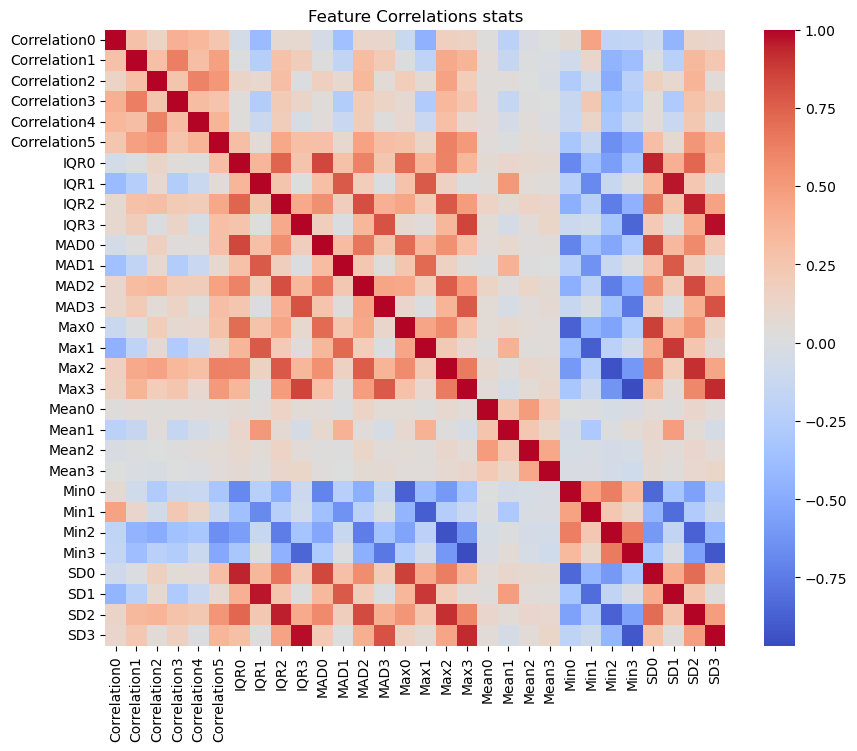

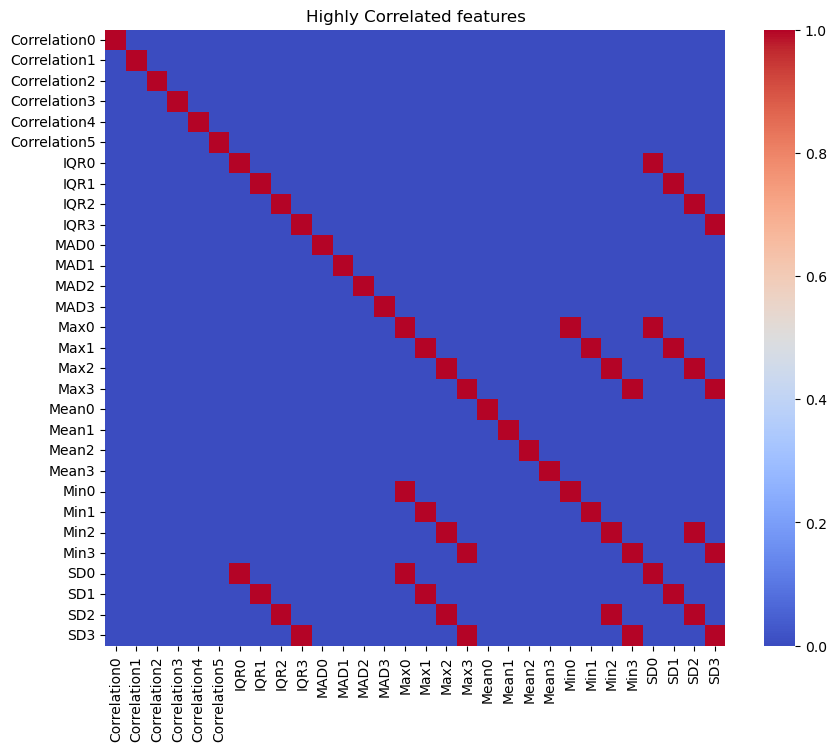

In [9]:
stats_features = group_feature_mapping['stats']
feature_corr_matrix = get_feature_feature_correlations(
    featured_df, stats_features)
plot_feature_feature_correlations(
        feature_corr_matrix, 'stats', results_dir)

## short version for file
# for fstem, feature_names in [
#         ('stats',stats_features), ('info', info_features),
#         ('freq', freq_features)] 
#     feature_corr_matrix = get_feature_feature_correlations(
#         featured_df, feature_names)
#     plot_feature_feature_correlations(
#             feature_corr_matrix, fstem, results_dir)



## `info` features



saving feature correlations heatmap to:
	../data/results/dreem_4secs/correlations_f2f_info.png
saving higly correlated features heatmap to:
	../data/results/dreem_4secs/highly_correlated_f2f_info.png


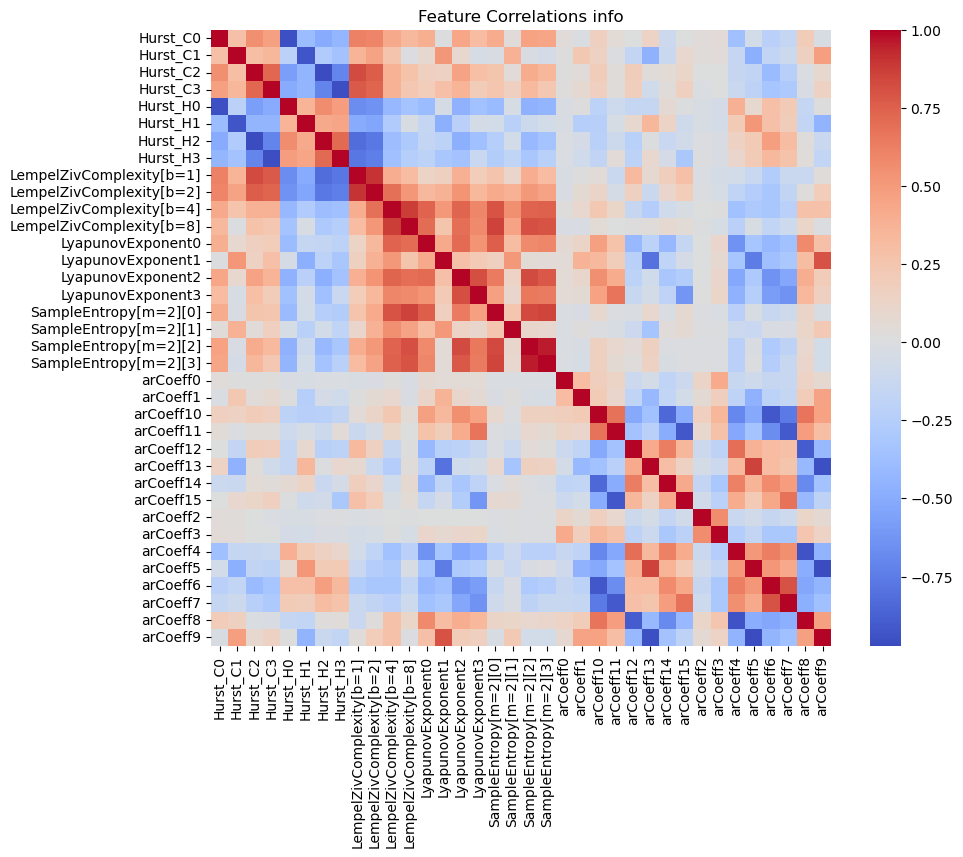

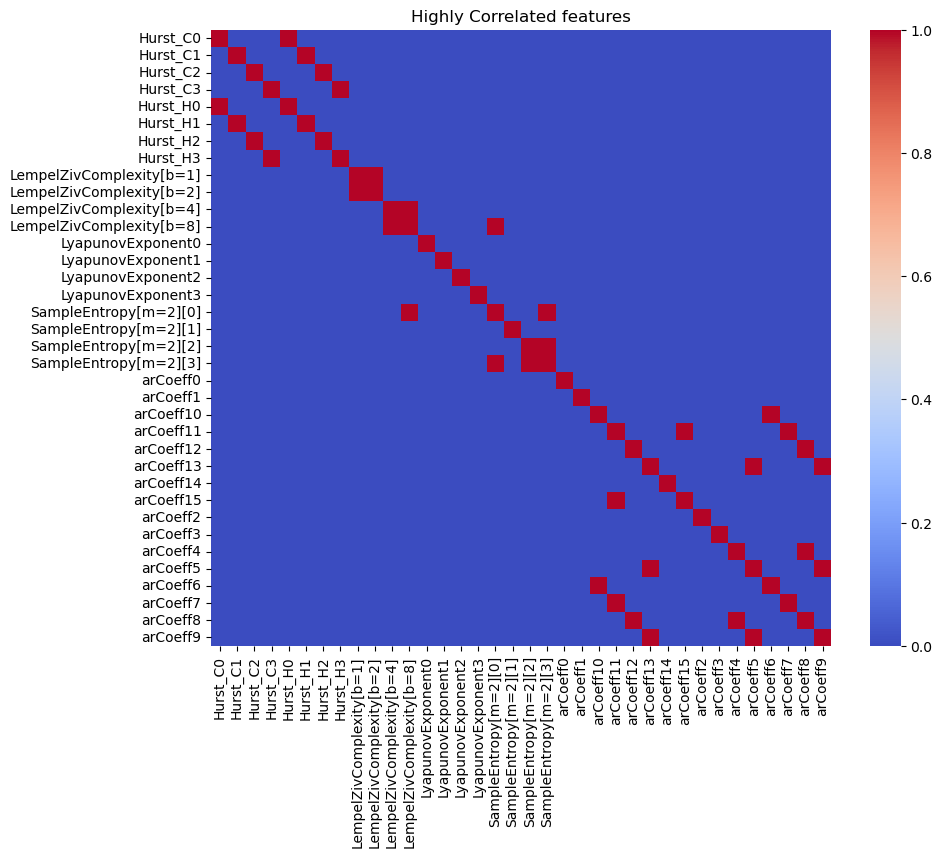

In [10]:
info_features = group_feature_mapping['info']
feature_corr_matrix = get_feature_feature_correlations(
    featured_df, info_features)
plot_feature_feature_correlations(
        feature_corr_matrix, 'info', results_dir)

# feature_corr_matrix = featured_df[info_features].corr()
# plt.figure(figsize=(10,8))
# sns.heatmap(feature_corr_matrix, cmap='coolwarm', annot=False)
# plt.title(f"Feature Correlations")

# high_corr_threshold = 0.85
# plt.figure(figsize=(10,8))
# sns.heatmap(np.abs(feature_corr_matrix) >= high_corr_threshold, cmap='coolwarm', annot=False)
# plt.title(f"Highly Correlated features")


## `freq` features


saving feature correlations heatmap to:
	../data/results/dreem_4secs/correlations_f2f_freq.png
saving higly correlated features heatmap to:
	../data/results/dreem_4secs/highly_correlated_f2f_freq.png


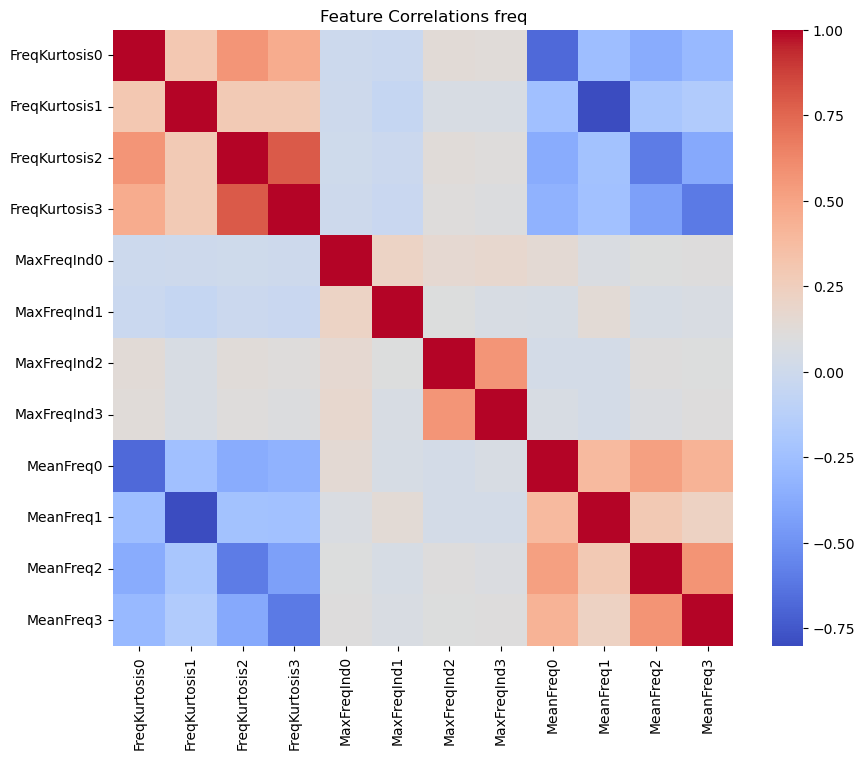

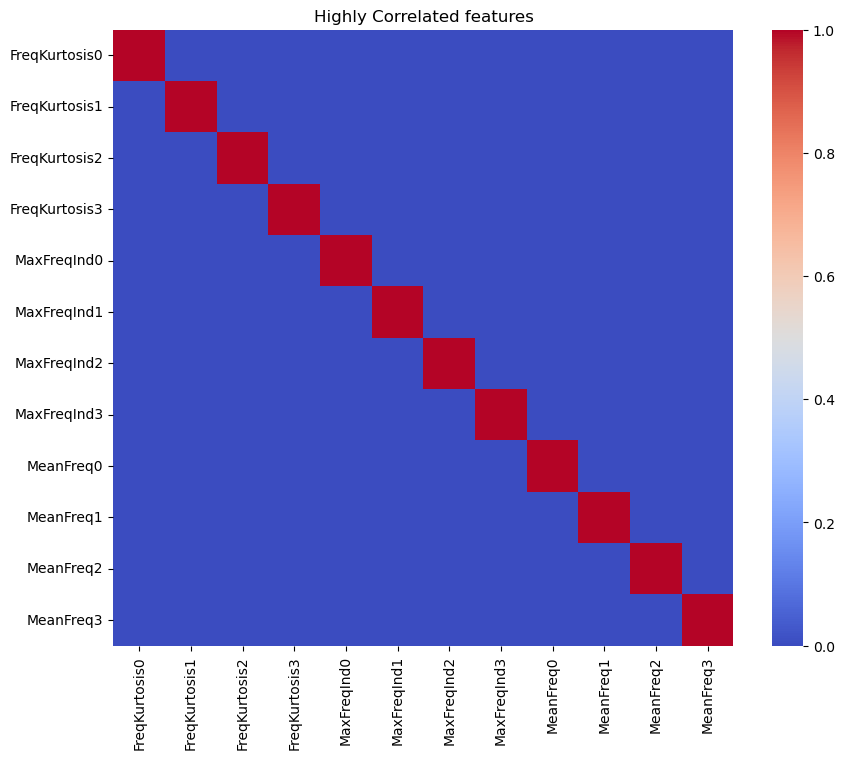

In [11]:
freq_features = group_feature_mapping['freq']
feature_corr_matrix = get_feature_feature_correlations(
    featured_df, freq_features)
plot_feature_feature_correlations(
        feature_corr_matrix, 'freq', results_dir)

# feature_corr_matrix = featured_df[freq_features].corr()
# plt.figure(figsize=(10,8))
# sns.heatmap(feature_corr_matrix, cmap='coolwarm', annot=False)
# plt.title(f"Feature Correlations")

# high_corr_threshold = 0.85
# plt.figure(figsize=(10,8))
# sns.heatmap(np.abs(feature_corr_matrix) >= high_corr_threshold, cmap='coolwarm', annot=False)
# plt.title(f"Highly Correlated features")


# Density of highly correlated features 

### What proportion of our feature pairs overall are highly correlated 

plotting density of correlated features to ../data/results/dreem_4secs/density_of_correlated_features.png


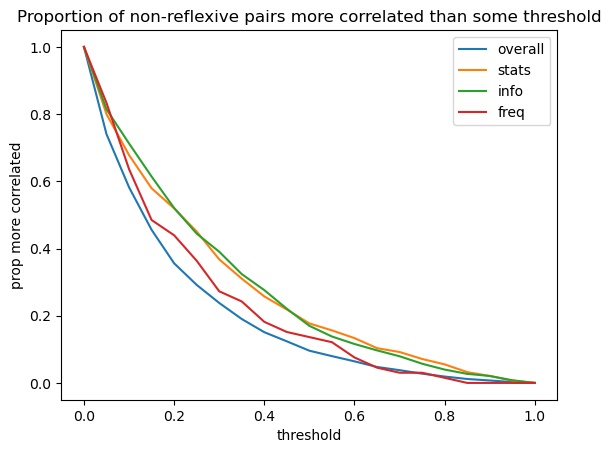

In [12]:
group_name_and_features = [
    ( 'overall', featured_df.columns ), ('stats', stats_features),
        ('info', info_features), ('freq', freq_features)]

plot_density_of_correlated_features(featured_df, results_dir, group_name_and_features)